<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21009 entries, 0 to 21008
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   PatUniqueID        21009 non-null  object        
 1   Age                21009 non-null  float64       
 2   Sex                21009 non-null  object        
 3   Ethnicity          21001 non-null  object        
 4   Race               20999 non-null  object        
 5   ZIP                20999 non-null  object        
 6   PCP_ID             20407 non-null  object        
 7   TobaccoUse         21009 non-null  object        
 8   PackYrs            8654 non-null   float64       
 9   QuitYrs            8230 non-null   float64       
 10  QuitDT             8230 non-null   datetime64[ns]
 11  Latest_LDCT        1118 non-null   datetime64[ns]
 12  LungCancerHistory  21009 non-null  int64         
dtypes: datetime64[ns](2), float64(3), int64(1), object(7)
memory 

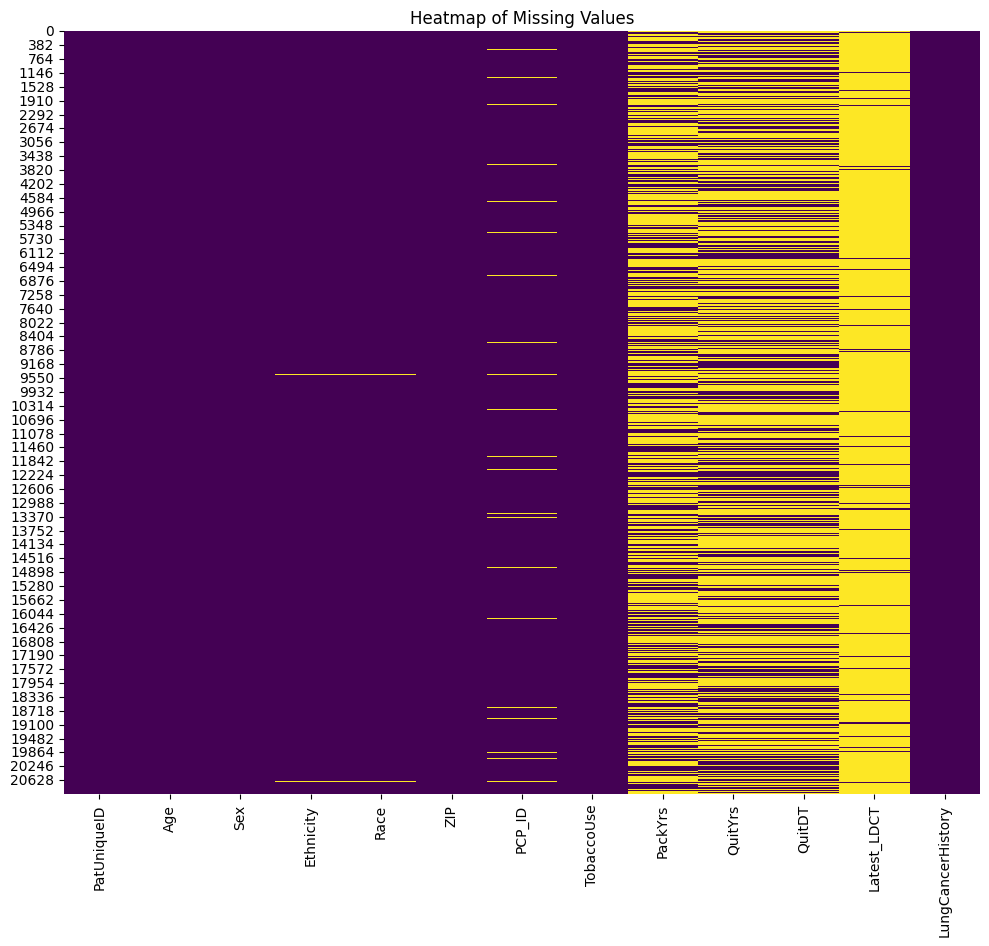

Number of entries with ZIP codes less than 5 digits: 27
Number of entries with ZIP codes greater than 5 digits: 3395
Count of 1 values in boolean fields:
 LungCancerHistory                   183
TobaccoUse_Every Day               6493
TobaccoUse_Former                 13071
TobaccoUse_Heavy Smoker             240
TobaccoUse_Light Smoker             233
TobaccoUse_Some Days                939
Sex_Female                        10674
Sex_Male                          10308
Race_Black or African American      848
Race_Other                          653
Race_White                        19182
Ethnicity_Unknown                   603
Latest_LDCT_Exists                 1118
Ethnicity_Non-Hispanic            19960
Ethnicity_Hispanic                  411
dtype: int64
Count of non-null values in other fields:
 Age        20982
ZIP        20982
PackYrs     8647
QuitYrs     8226
dtype: int64


In [1]:
# EDA
# Import Libraries
import pandas as pd
from sklearn.impute import SimpleImputer
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

#Load the dataset
df = pd.read_excel("Tobacco Screening Patient.xlsx")

#Display basic information
print(df.info())
print(df.describe())
print(df.head())

lung_cancer_history_count = df['LungCancerHistory'].sum()
print(f"Number of entries where LungCancerHistory is 1: {lung_cancer_history_count}")

#Print missing values
missing_values = df.isnull().sum()
print("Missing values in each column:\n", missing_values)

#Plot missing values
plt.figure(figsize=(10, 10))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Heatmap of Missing Values')
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
plt.show()

#Set ZIP as a string
df['ZIP'] = df['ZIP'].astype(str)

#Find entries with ZIP codes less than 5 digits
zip_less_than_5_digits = df[df['ZIP'].apply(lambda x: len(x) < 5)]

#Find entries with ZIP codes greater than 5 digits
zip_greater_than_5_digits = df[df['ZIP'].apply(lambda x: len(x) > 5)]

#Count the entries
count_less_than_5_digits = zip_less_than_5_digits.shape[0]
count_greater_than_5_digits = zip_greater_than_5_digits.shape[0]

print(f"Number of entries with ZIP codes less than 5 digits: {count_less_than_5_digits}")
print(f"Number of entries with ZIP codes greater than 5 digits: {count_greater_than_5_digits}")

#Replace all blanks with NaN/NaT
df.replace("", pd.NA, inplace=True)

#Drop PatUniqueID and PCP_ID columns
df.drop(columns=['PatUniqueID', 'PCP_ID'], inplace=True)

#Convert all ZIP codes to 5 digit
df['ZIP'] = df['ZIP'].astype(str)
df['ZIP'] = df['ZIP'].apply(lambda x: x.zfill(5) if len(x) == 5 else x[:5])

#Handle ZIP codes less than 5 digits by dropping
df = df[df['ZIP'].apply(lambda x: len(x) == 5)]

#Convert categorical variables to numeric using one-hot encoding
#setting drop_first=True to avoid multicollinearity
df = pd.get_dummies(df, columns=['TobaccoUse', 'Sex', 'Race', 'Ethnicity'])
boolean_columns = df.select_dtypes(include=['bool']).columns
df[boolean_columns] = df[boolean_columns].astype(int)

#Convert date fields to datetime format
df['QuitDT'] = pd.to_datetime(df['QuitDT'], errors='coerce')
df['Latest_LDCT'] = pd.to_datetime(df['Latest_LDCT'], errors='coerce')

#Calculate QuitYrs if QuitDT is available and QuitYrs is missing
current_year = datetime.now().year
df['QuitYrs'] = df.apply(
    lambda row: current_year - row['QuitDT'].year if pd.notna(row['QuitDT']) and
    pd.isna(row['QuitYrs']) else row['QuitYrs'], axis=1
)
#Drop QuitDT column
df.drop(columns=['QuitDT'], inplace=True)

#Drop TobaccoUse_Smoker, Current Status Unknown
#there are only 6 records and none have lung cancer history
df.drop(columns=['TobaccoUse_Smoker, Current Status Unknown'], inplace=True)

#Create a binary indicator for existing Latest_LDCT
df['Latest_LDCT_Exists'] = df['Latest_LDCT'].notna().astype(int)
df.drop(columns=['Latest_LDCT'], inplace=True)

#Combine Race_XXX fields into Race_Other except for Race_White and Race_Black
#or African American
race_columns = [col for col in df.columns if col.startswith('Race_')
                and col not in ['Race_White', 'Race_Black or African American',
                                'Race_Other']]
df['Race_Other'] = df[race_columns].sum(axis=1)
df.drop(columns=race_columns, inplace=True)

#Combine Ethnicity_XXX fields into Ethnicity_Hispanic, Ethnicity_Non-Hispanic,
#Ethnicity_Other
df['Ethnicity_Non-Hispanic'] = df['Ethnicity_Not Hispanic, Latino/a, or Spanish origin']
df['Ethnicity_Unknown'] = df[['Ethnicity_Decline to Answer', 'Ethnicity_Unknown']
                             ].sum(axis=1)
df['Ethnicity_Hispanic'] = df[['Ethnicity_Cuban', 'Ethnicity_Mexican, Mexican American, or Chicano/a',
                               'Ethnicity_Other Hispanic, Latino/a, or Spanish origin', 'Ethnicity_Puerto Rican']
                               ].sum(axis=1)

# Drop the original Ethnicity columns
ethnicity_columns = ['Ethnicity_Cuban', 'Ethnicity_Decline to Answer',
                     'Ethnicity_Mexican, Mexican American, or Chicano/a',
                     'Ethnicity_Not Hispanic, Latino/a, or Spanish origin',
                     'Ethnicity_Other Hispanic, Latino/a, or Spanish origin',
                     'Ethnicity_Puerto Rican']
df.drop(columns=ethnicity_columns, inplace=True)

#Drop columns with all zero values
df = df.loc[:, (df != 0).any(axis=0)]

#Boolean fields calculations
boolean_fields = [col for col in df.columns if set(df[col].dropna().unique()) <= {0, 1}]
one_counts = df[boolean_fields].sum()
print("Count of 1 values in boolean fields:\n", one_counts)

#Non-null counts for all other fields
non_null_counts = df.drop(columns=boolean_fields).notna().sum()
print("Count of non-null values in other fields:\n", non_null_counts)

#Export DataFrame to Excel
df.to_excel('Cleaned UHS Data.xlsx', index=False)

# one_counts_less_than_105 = one_counts[one_counts < 105]
# print("Boolean columns with count of 1 values less than 105:\n", one_counts_less_than_105)

# # Plot count of 1 values for boolean columns with less than 105 occurrences
# plt.figure(figsize=(15, 5))  # Set the figure size before plotting
# sns.barplot(x=one_counts_less_than_105.index, y=one_counts_less_than_105.values)
# plt.title('Count of 1 Values in Boolean Fields with Less Than 105 Occurrences')
# plt.xticks(rotation=45, ha='right', fontsize=8)
# plt.tight_layout()
# plt.subplots_adjust(bottom=0.3)
# plt.show()

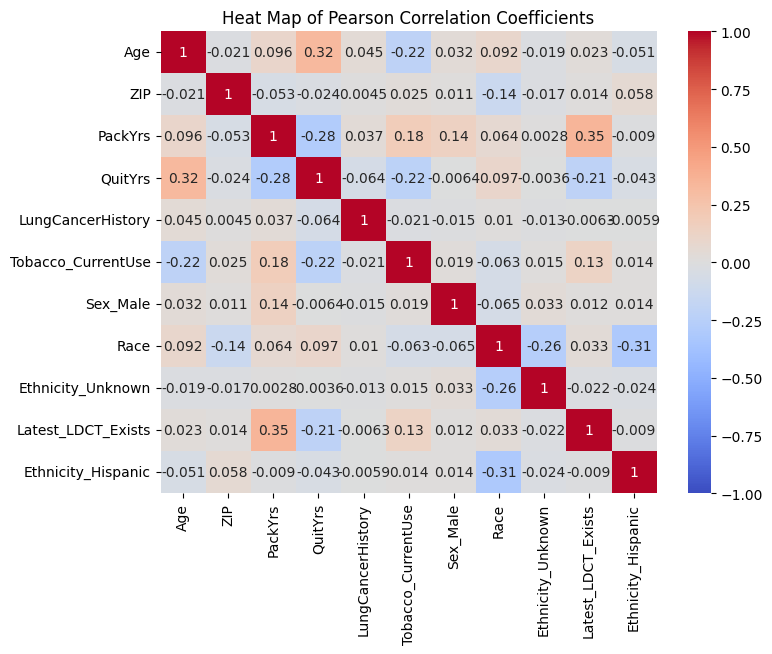

             Variable        VIF
0               const  94.258652
1                 Age   1.165307
2             PackYrs   1.298748
3             QuitYrs   1.365525
4  Tobacco_CurrentUse   1.062461
5            Sex_Male   1.027066
6                Race   1.238952
7   Ethnicity_Unknown   1.091058
8  Ethnicity_Hispanic   1.130979
9  Latest_LDCT_Exists   1.221729
      const    Age  PackYrs  QuitYrs  Tobacco_CurrentUse  Sex_Male  Race  \
0       1.0  68.70     0.00    22.42                   0         0     1   
1       1.0  46.74    15.00     1.50                   0         0     1   
2       1.0  47.42    10.00     9.42                   0         0     1   
3       1.0  62.75    42.10     2.92                   0         0     1   
4       1.0  70.43    22.50     9.75                   0         0     1   
...     ...    ...      ...      ...                 ...       ...   ...   
4496    1.0  62.24    13.50    22.42                   0         0     1   
4497    1.0  63.01    47.00  

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


             Variable        VIF
0               const  95.296524
1                 Age   1.471094
2             PackYrs   1.394721
3             QuitYrs   2.573611
4  Tobacco_CurrentUse   1.756990
5            Sex_Male   1.054649
6                Race   1.267954
7   Ethnicity_Unknown   1.092112
8  Ethnicity_Hispanic   1.124354
9  Latest_LDCT_Exists   1.222625
       const    Age     PackYrs    QuitYrs  Tobacco_CurrentUse  Sex_Male  \
0        1.0  53.41    4.100000   5.870218                   1         1   
1        1.0  46.55   18.119650  -1.515341                   1         0   
2        1.0  63.71   30.202095   9.042871                   1         1   
3        1.0  56.67   21.742781   5.023014                   1         0   
4        1.0  45.68   10.000000  -0.864467                   1         0   
...      ...    ...         ...        ...                 ...       ...   
20977    1.0  48.48   21.210000  -0.641134                   1         0   
20978    1.0  62.86   22.5734

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                     0                  1                  2         3
0               Model:              Logit            Method:       MLE
1  Dependent Variable:  LungCancerHistory  Pseudo R-squared:     0.089
2                Date:   2024-07-05 00:42               AIC:  190.0180
3    No. Observations:               1189               BIC:  240.8267
4            Df Model:                  9    Log-Likelihood:   -85.009
5        Df Residuals:               1179           LL-Null:   -93.292
6           Converged:             0.0000       LLR p-value:  0.055962
7      No. Iterations:            35.0000             Scale:    1.0000
                           Logit Regression Results                           
Dep. Variable:      LungCancerHistory   No. Observations:                 1189
Model:                          Logit   Df Residuals:                     1179
Method:                           MLE   Df Model:                            9
Date:                Fri, 05 Jul 2024   Pseud

In [3]:
# Analysis
# Import Libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pointbiserialr
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression

data = pd.read_excel('Cleaned UHS Data.xlsx')



# Frequency encoding for ZIP
zip_freq = data['ZIP'].value_counts().to_dict()
data['ZIP'] = data['ZIP'].map(zip_freq)

# Since we have sex_male binary column, drop sex_female column
data = data.drop(columns=['Sex_Female'])

# Since we have hispanic binary column, drop non-hispanic column
data = data.drop(columns=['Ethnicity_Non-Hispanic'])


# Drop records that have unknown tobacco usage
condition1 = (data['TobaccoUse_Heavy Smoker'] == 0) & (data['TobaccoUse_Light Smoker'] == 0) & (data['TobaccoUse_Every Day'] == 0) & (data['TobaccoUse_Some Days'] == 0) & (data['TobaccoUse_Former'] == 0)
data = data[~condition1]

# One column if tobacco current use or former
data['TobaccoUse_Every Day'] = data.apply(lambda row: 1 if row['TobaccoUse_Heavy Smoker'] == 1 or row['TobaccoUse_Light Smoker'] == 1
                                          or row['TobaccoUse_Every Day'] == 1 or row['TobaccoUse_Some Days'] == 1 else 0, axis=1)

# Drop columns
data = data.drop(columns=['TobaccoUse_Heavy Smoker', 'TobaccoUse_Light Smoker','TobaccoUse_Some Days','TobaccoUse_Former'])

data.rename(columns={'TobaccoUse_Every Day': 'Tobacco_CurrentUse'},inplace=True)

# One column if Race is white or not
data['Race_White'] = data.apply(lambda row: 1 if row['Race_White'] == 1  else 0, axis=1)

data = data.drop(columns=['Race_Black or African American', 'Race_Other'])

data.rename(columns={'Race_White': 'Race'},inplace=True)



# Correlation of the features

plt.figure(figsize=(8, 6))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Heat Map of Pearson Correlation Coefficients')
plt.show()







# Main analysis
# Create dataset for causal analysis with variables of interest

data1 = data[['Age','PackYrs','QuitYrs','LungCancerHistory','Tobacco_CurrentUse','Sex_Male','Race','Ethnicity_Unknown','Ethnicity_Hispanic','Latest_LDCT_Exists']]

# We remove all records with any blank values
data2 = data1.dropna()

data2 = data2.reset_index(drop=True)


X = data2.drop('LungCancerHistory', axis=1)
y = data2['LungCancerHistory']

X = sm.add_constant(X)

# Check multicollinearity by vif scores
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif)

print(X)
print(y)

# Fit OLS regression model
ols_model = sm.Logit(y,X).fit()

print("Without Imputation")
# Print the summary of the model with actual feature names
print(ols_model.summary())
ols_summary = ols_model.summary2().tables[1]


# Create a DataFrame with feature names and their corresponding coefficients
coefficients = ols_model.params
feature_importance = pd.DataFrame({'Feature': coefficients.index, 'Coefficient': coefficients.values})

# Sort the features by the absolute value of their coefficients
feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values('Abs_Coefficient', ascending=False)

print("Feature Importance:")
print(feature_importance[['Feature', 'Coefficient']])


feature_importance = pd.DataFrame({
    'Feature': coefficients,
    'Importance': np.abs(ols_model.params[1:])  # exclude the intercept
}).sort_values(by='Importance', ascending=False)












# Sub Sample Analysis
# Impute blank quityrs and packyrs by regression instead of dropping
# Regression Imputation for Pack_Years Quityrs
def regression_imputation(data1, target_col, predictors):
    train_data = data1[data1[target_col].notna()]
    test_data = data1[data1[target_col].isna()]

    X_train = train_data[predictors]
    y_train = train_data[target_col]
    X_test = test_data[predictors]

    model = LinearRegression()
    model.fit(X_train, y_train)
    data1.loc[data1[target_col].isna(), target_col] = model.predict(X_test)

    return data1

# Define the predictors (excluding Pack_Years and Quit_Years)
predictors = ['Tobacco_CurrentUse', 'Age', 'Sex_Male', 'Race', 'Ethnicity_Hispanic','Ethnicity_Unknown','LungCancerHistory','Latest_LDCT_Exists']
predictors1 = ['PackYrs','Tobacco_CurrentUse', 'Age', 'Sex_Male', 'Race', 'Ethnicity_Hispanic','Ethnicity_Unknown','LungCancerHistory','Latest_LDCT_Exists']

# Impute Pack_Years
data1 = regression_imputation(data1, 'PackYrs', predictors)

# Impute Quit_Years
data1 = regression_imputation(data1, 'QuitYrs', predictors1)






# General Regression again

data3 = data1
X = data3.drop('LungCancerHistory', axis=1)
y = data3['LungCancerHistory']

X = sm.add_constant(X)

# Check multicollinearity by vif scores
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif)

print(X)
print(y)

# Fit OLS regression model
ols_model = sm.Logit(y,X).fit()
print('With Imputation')
# Print the summary of the model with actual feature names
print(ols_model.summary())
ols_summary = ols_model.summary2().tables[1]


# Create a DataFrame with feature names and their corresponding coefficients
coefficients = ols_model.params
feature_importance = pd.DataFrame({'Feature': coefficients.index, 'Coefficient': coefficients.values})

# Sort the features by the absolute value of their coefficients
feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values('Abs_Coefficient', ascending=False)

print("Feature Importance:")
print(feature_importance[['Feature', 'Coefficient']])


feature_importance = pd.DataFrame({
    'Feature': coefficients,
    'Importance': np.abs(ols_model.params[1:])  # exclude the intercept
}).sort_values(by='Importance', ascending=False)



























# Sub Sampling based on Age

age_bins = [0, 30, 50, 70, 80, 100]
age_labels = ['<30', '30-50', '50-70', '70-80', '80+']

# Create a new column for age groups
data1['Age_Group'] = pd.cut(data1['Age'], bins=age_bins, labels=age_labels)
print(data1['Age_Group'])

def logistic_regression_subsample(data1, group_col, target_col, predictors):
    # Results dictionary
    results = {}

    # Iterate over each unique value in the group_col
    for group in data1[group_col].unique():
        # Create a sub-sample
        subset = data1[data1[group_col] == group]

        # Define the independent variables (X) and the dependent variable (y)
        X = subset[predictors]
        y = subset[target_col]

        # Add a constant to the model
        X = sm.add_constant(X)

        try:
            # Fit the logistic regression model
            model = sm.Logit(y, X).fit(disp=False)
            print(model.summary2().tables[0])
            results[group] = model.summary2().tables[1]
            print(model.summary())
        except np.linalg.LinAlgError:
            print(f"Singular matrix error for group: {group}")
        except Exception as e:
            print(f"Error for group: {group}, {e}")

    return results

# Define the target and predictors
target_col = 'LungCancerHistory'
predictors = ['PackYrs', 'QuitYrs', 'Tobacco_CurrentUse', 'Age','Sex_Male', 'Race','Ethnicity_Unknown','Ethnicity_Hispanic','Latest_LDCT_Exists']

# Perform logistic regression for each sub-sample defined by 'Gender'
results = logistic_regression_subsample(data1, 'Age_Group', target_col, predictors)

# Print the results
for Age_Group, result in results.items():
    print(f"\nResults for Age_Group: {Age_Group}")
    print(result)

with pd.ExcelWriter('logistic_regression_results.xlsx') as writer:
    ols_summary.to_excel(writer, sheet_name='OLS_Summary_main')
    feature_importance.to_excel(writer, sheet_name='Feature_Importance_main')
    for age_group, result in results.items():
        result.to_excel(writer, sheet_name=f'Sub_Sample_Age_Group_{age_group}')

print("Results have been exported to 'logistic_regression_results.xlsx'.")